In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from python.dlf.dlf import DLF
from python.util import BATCH_SIZE, DataMode, ModelMode
from python.dataset.data_reader import read_dataset

In [133]:
dataset = read_dataset('../data', '2997')
features, bids, _ = dataset.next_loss()

data size  43803 

data size  268634 



In [134]:
max_z = -1
max_id = 0

for i, info in enumerate(bids):
    z, _ = info
    if max_z < z < 60:
        max_z = z
        max_id = i

z = max_z
idx = max_id
bid_range = np.arange(1, 100)

In [135]:
print('market price=%d, bid=%d' % (z, bids[idx][1]))

market price=58, bid=2


In [136]:
def get_probabilities(model):
    h = model.predict_on_batch([features, bids])
    h = h.numpy()[idx]

    distribution = []
    S = []
    W = []

    for i in bid_range:
        prefix = 1
        for j in range(i):
            prefix *= h[j]

        prob = (1 - h[i]) * prefix
        distribution.append(prob)
        S.append(prefix)
        W.append(1 - prefix)

    return {'Distribution': distribution, 'Lossing': S, 'Winning': W}

In [137]:
def draw_plot(probability_dict):
    fig, ax = plt.subplots(len(probability_dict))
    fig.set_figheight(4)
    fig.set_figwidth(5)

    i = 0
    for name, values in probability_dict.items():
        ax[i].plot(bid_range, values, label='probability')
        ax[i].vlines(z, min(values), max(values), label='market price', color='red')
        ax[i].set_xlabel('bids')
        ax[i].set_ylabel(name)
        ax[i].legend()

        i += 1
    plt.show()

def draw_single_plot(probability_dicts):
    fig, ax = plt.subplots(len(probability_dicts[0]), len(probability_dicts))
    fig.set_figheight(30)
    fig.set_figwidth(10)

    for j in range(len(probability_dicts)):
        i = 0
        for name, values in probability_dicts[j].items():
            ax[i][j].plot(bid_range, values, label='probability')
            ax[i][j].vlines(z, min(values), max(values), label='market price', color='red')
            ax[i][j].set_xlabel('bids')
            ax[i][j].set_ylabel(name)
            ax[i][j].legend()

            i += 1
    plt.show()

In [138]:
def read_checkpoint(model_name):
    checkpoint_path = '../output/checkpoint/aws/' + model_name + '/cp-{epoch:02d}.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    return tf.train.latest_checkpoint(checkpoint_dir)

In [139]:
dlf = DLF(ModelMode.DLF)
dlf.build(input_shape=([BATCH_SIZE, 16], [BATCH_SIZE, 2]))

latest = read_checkpoint('dlf_2997_all__0.25_0.75_0.0001_20200502_1437')
dlf.load_weights(latest)

In [140]:
dlf_attention = DLF(ModelMode.DLF_ATTENTION)
dlf_attention.build(input_shape=([BATCH_SIZE, 16], [BATCH_SIZE, 2]))

latest = read_checkpoint('dlf_attention_2997_all__0.25_0.75_0.0001_20200502_1753')
dlf_attention.load_weights(latest)

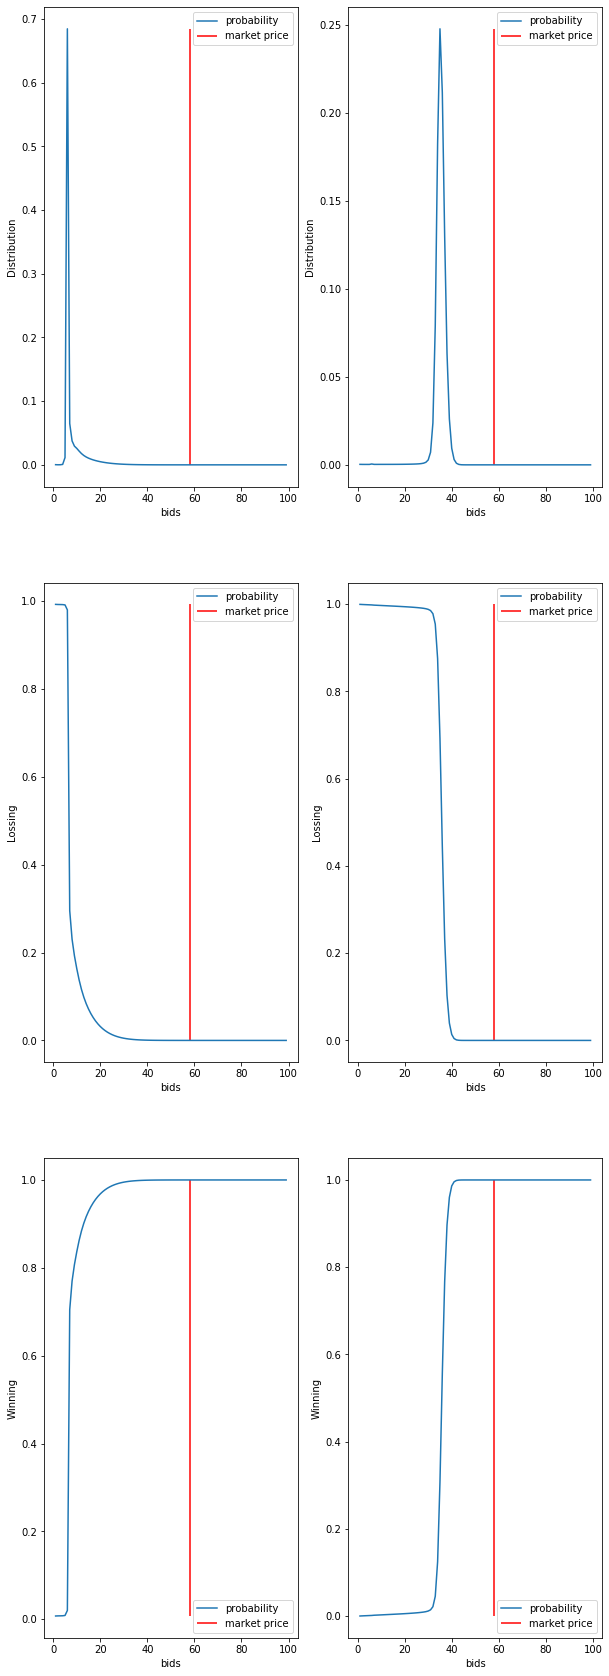

In [141]:
dlf_prob_dict = get_probabilities(dlf)
dlf_attention_prod_dict = get_probabilities(dlf_attention)
# draw_plot(prob_dict)
draw_single_plot([dlf_prob_dict, dlf_attention_prod_dict])